=============================================================================
EDA COMPLETO - DETECCIÓN DE MENSAJES DE ODIO EN YOUTUBE
=============================================================================

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [27]:
# =============================================================================
# 1. CARGA Y EXPLORACIÓN INICIAL
# =============================================================================

print("="*80)
print("1. CARGA Y EXPLORACIÓN INICIAL DEL DATASET")
print("="*80)

# Cargar datos
df = pd.read_csv('../data/youtoxic_english_1000.csv')

print(f"\n📊 DIMENSIONES DEL DATASET")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")

print(f"\n📋 COLUMNAS DISPONIBLES:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n🔍 PRIMERAS 3 FILAS:")
print(df.head(3))

print(f"\n🔍 ÚLTIMAS 3 FILAS:")
print(df.tail(3))

print(f"\n📊 TIPOS DE DATOS:")
print(df.dtypes)

print(f"\n📊 INFORMACIÓN GENERAL:")
print(df.info())


1. CARGA Y EXPLORACIÓN INICIAL DEL DATASET

📊 DIMENSIONES DEL DATASET
   Filas: 1,000
   Columnas: 15

📋 COLUMNAS DISPONIBLES:
    1. CommentId
    2. VideoId
    3. Text
    4. IsToxic
    5. IsAbusive
    6. IsThreat
    7. IsProvocative
    8. IsObscene
    9. IsHatespeech
   10. IsRacist
   11. IsNationalist
   12. IsSexist
   13. IsHomophobic
   14. IsReligiousHate
   15. IsRadicalism

🔍 PRIMERAS 3 FILAS:
              CommentId      VideoId  \
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI   
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   

                                                                                                  Text  \
0  If only people would just take a step back and not make this case about them, because it wasn't ...   
1  Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I...   
2  \nDont you reckon them 'black lives matter' banners being held by white cunts is  kinda patroniz...   



In [28]:
# =============================================================================
# 2. ANÁLISIS DE CALIDAD DE DATOS
# =============================================================================

print("\n" + "="*80)
print("2. ANÁLISIS DE CALIDAD DE DATOS")
print("="*80)

print(f"\n🔍 VALORES NULOS POR COLUMNA:")
nulos = df.isnull().sum()
porcentaje_nulos = (nulos / len(df)) * 100
df_nulos = pd.DataFrame({
    'Columna': nulos.index,
    'Nulos': nulos.values,
    'Porcentaje': porcentaje_nulos.values
})
print(df_nulos[df_nulos['Nulos'] > 0])
print(f"\n   Total de valores nulos: {df.isnull().sum().sum():,}")

print(f"\n🔍 VALORES DUPLICADOS:")
duplicados = df.duplicated().sum()
print(f"   Filas completamente duplicadas: {duplicados:,} ({(duplicados/len(df)*100):.2f}%)")

duplicados_texto = df['Text'].duplicated().sum()
print(f"   Comentarios duplicados (solo texto): {duplicados_texto:,} ({(duplicados_texto/len(df)*100):.2f}%)")

print(f"\n🔍 COMENTARIOS VACÍOS O SOLO ESPACIOS:")
vacios = df['Text'].isna().sum()
solo_espacios = df['Text'].str.strip().eq('').sum() if not df['Text'].isna().all() else 0
print(f"   Comentarios vacíos (NaN): {vacios:,}")
print(f"   Comentarios solo con espacios: {solo_espacios:,}")


2. ANÁLISIS DE CALIDAD DE DATOS

🔍 VALORES NULOS POR COLUMNA:
Empty DataFrame
Columns: [Columna, Nulos, Porcentaje]
Index: []

   Total de valores nulos: 0

🔍 VALORES DUPLICADOS:
   Filas completamente duplicadas: 0 (0.00%)
   Comentarios duplicados (solo texto): 3 (0.30%)

🔍 COMENTARIOS VACÍOS O SOLO ESPACIOS:
   Comentarios vacíos (NaN): 0
   Comentarios solo con espacios: 0



3. ANÁLISIS DE VARIABLES OBJETIVO

📊 DISTRIBUCIÓN DE CADA ETIQUETA:
Etiqueta                Positivos        %    Negativos        %
-----------------------------------------------------------------
IsToxic                       462   46.20%          538   53.80%
IsAbusive                     353   35.30%          647   64.70%
IsThreat                       21    2.10%          979   97.90%
IsProvocative                 161   16.10%          839   83.90%
IsObscene                     100   10.00%          900   90.00%
IsHatespeech                  138   13.80%          862   86.20%
IsRacist                      125   12.50%          875   87.50%
IsNationalist                   8    0.80%          992   99.20%
IsSexist                        1    0.10%          999   99.90%
IsHomophobic                    0    0.00%        1,000  100.00%
IsReligiousHate                12    1.20%          988   98.80%
IsRadicalism                    0    0.00%        1,000  100.00%

🎯 VARIABLE OBJETIVO

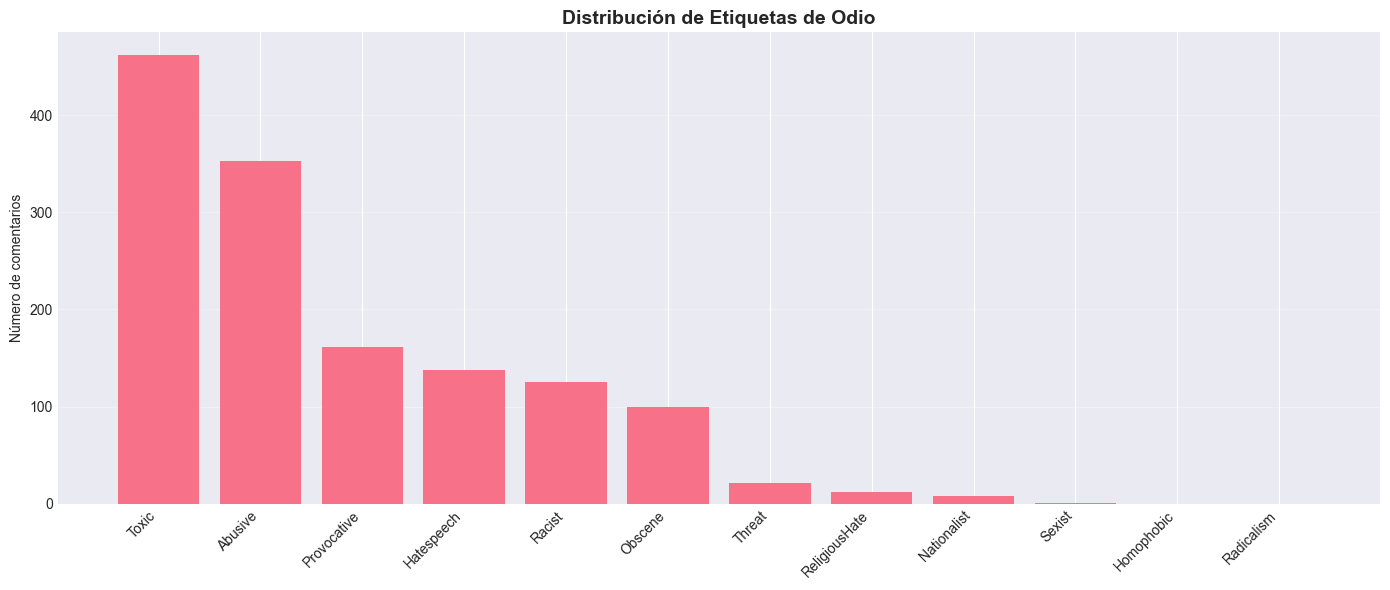

In [29]:
# =============================================================================
# 3. ANÁLISIS DE VARIABLES OBJETIVO (ETIQUETAS)
# =============================================================================

print("\n" + "="*80)
print("3. ANÁLISIS DE VARIABLES OBJETIVO")
print("="*80)

# Columnas de etiquetas
label_columns = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 
                 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist',
                 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

print(f"\n📊 DISTRIBUCIÓN DE CADA ETIQUETA:")
print(f"{'Etiqueta':<20} {'Positivos':>12} {'%':>8} {'Negativos':>12} {'%':>8}")
print("-" * 65)

for col in label_columns:
    positivos = df[col].sum()
    pct_pos = (positivos / len(df)) * 100
    negativos = len(df) - positivos
    pct_neg = (negativos / len(df)) * 100
    print(f"{col:<20} {positivos:>12,} {pct_pos:>7.2f}% {negativos:>12,} {pct_neg:>7.2f}%")

# Crear variable objetivo general
df['IsHate'] = df[label_columns].max(axis=1)
hate_count = df['IsHate'].sum()
no_hate_count = len(df) - hate_count

print(f"\n🎯 VARIABLE OBJETIVO GENERAL (IsHate = cualquier tipo de odio):")
print(f"   Mensajes de ODIO: {hate_count:,} ({(hate_count/len(df)*100):.2f}%)")
print(f"   Mensajes NORMALES: {no_hate_count:,} ({(no_hate_count/len(df)*100):.2f}%)")
print(f"   RATIO DE DESBALANCEO: 1:{(no_hate_count/hate_count):.2f}")

print(f"\n📊 MENSAJES CON MÚLTIPLES ETIQUETAS:")
df['num_labels'] = df[label_columns].sum(axis=1)
print(df['num_labels'].value_counts().sort_index())

print(f"\n🔥 COMBINACIONES MÁS FRECUENTES DE ETIQUETAS:")
# Ver qué combinaciones aparecen más
label_combinations = df[df['IsHate'] == 1][label_columns].apply(
    lambda x: ', '.join([col.replace('Is', '') for col, val in zip(label_columns, x) if val == 1]), 
    axis=1
)
print(label_combinations.value_counts().head(10))

# Visualización: Distribución de etiquetas
plt.figure(figsize=(14, 6))
label_counts = df[label_columns].sum().sort_values(ascending=False)
plt.bar(range(len(label_counts)), label_counts.values)
plt.xticks(range(len(label_counts)), 
           [label.replace('Is', '') for label in label_counts.index], 
           rotation=45, ha='right')
plt.ylabel('Número de comentarios')
plt.title('Distribución de Etiquetas de Odio', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()



4. ANÁLISIS DE TEXTO - CARACTERÍSTICAS BÁSICAS

📏 ESTADÍSTICAS DE LONGITUD DEL TEXTO (GENERAL):
        char_count   word_count  sentence_count  avg_word_length
count  1000.000000  1000.000000     1000.000000      1000.000000
mean    185.554000    33.776000        3.442000         5.579758
std     270.780777    49.069498        3.385868         1.508408
min       3.000000     1.000000        1.000000         3.000000
25%      47.000000     9.000000        2.000000         5.028318
50%     101.000000    19.000000        2.000000         5.400000
75%     217.000000    39.000000        4.000000         5.876250
max    4421.000000   815.000000       60.000000        40.000000

📏 COMPARATIVA: MENSAJES DE ODIO vs NORMALES

Métrica                      Odio (Media)  Normal (Media)   Diferencia
----------------------------------------------------------------------
char_count                         189.39          182.26         7.13
word_count                          34.60           33.07  

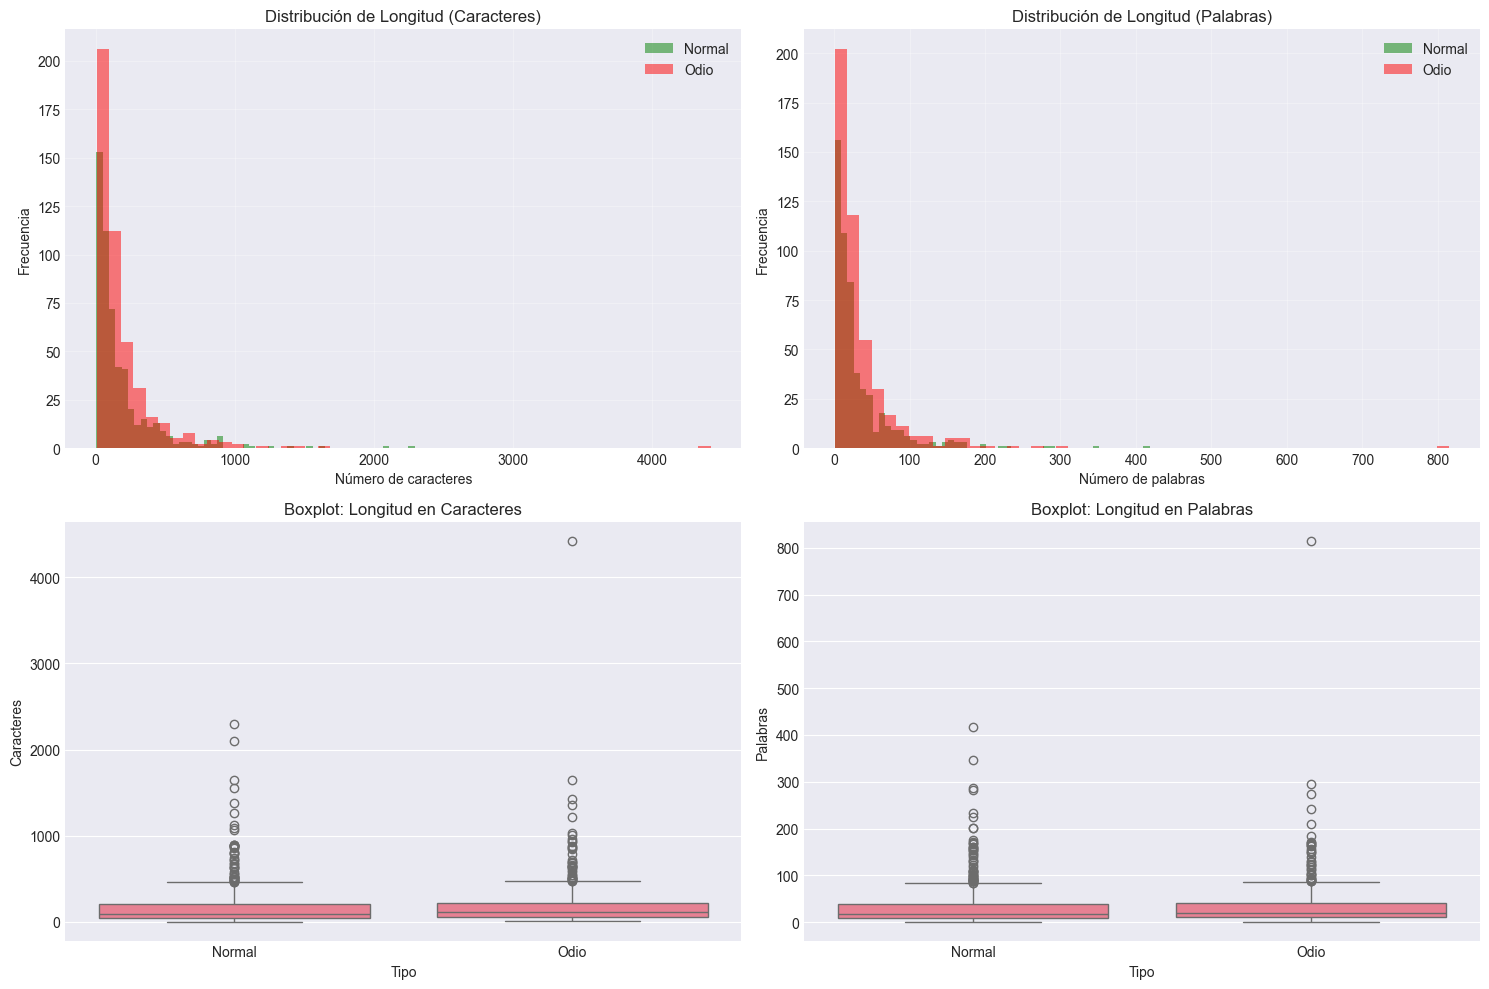

In [30]:
# =============================================================================
# 4. ANÁLISIS DE TEXTO - CARACTERÍSTICAS BÁSICAS
# =============================================================================

print("\n" + "="*80)
print("4. ANÁLISIS DE TEXTO - CARACTERÍSTICAS BÁSICAS")
print("="*80)

# Longitudes
df['char_count'] = df['Text'].astype(str).str.len()
df['word_count'] = df['Text'].astype(str).str.split().str.len()
df['sentence_count'] = df['Text'].astype(str).str.count(r'[.!?]+') + 1
df['avg_word_length'] = df['char_count'] / df['word_count']

print(f"\n📏 ESTADÍSTICAS DE LONGITUD DEL TEXTO (GENERAL):")
stats_df = df[['char_count', 'word_count', 'sentence_count', 'avg_word_length']].describe()
print(stats_df)

print(f"\n📏 COMPARATIVA: MENSAJES DE ODIO vs NORMALES")
print(f"\n{'Métrica':<25} {'Odio (Media)':>15} {'Normal (Media)':>15} {'Diferencia':>12}")
print("-" * 70)

for col in ['char_count', 'word_count', 'sentence_count', 'avg_word_length']:
    hate_mean = df[df['IsHate'] == 1][col].mean()
    normal_mean = df[df['IsHate'] == 0][col].mean()
    diff = hate_mean - normal_mean
    print(f"{col:<25} {hate_mean:>15.2f} {normal_mean:>15.2f} {diff:>12.2f}")

print(f"\n📊 COMENTARIOS MÁS LARGOS Y MÁS CORTOS:")
print(f"\n   Top 3 comentarios MÁS LARGOS:")
for i, row in df.nlargest(3, 'char_count')[['Text', 'char_count', 'IsHate']].iterrows():
    print(f"   - {row['char_count']} chars | Odio: {row['IsHate']} | {row['Text'][:100]}...")

print(f"\n   Top 3 comentarios MÁS CORTOS (no vacíos):")
df_no_vacios = df[df['char_count'] > 0]
for i, row in df_no_vacios.nsmallest(3, 'char_count')[['Text', 'char_count', 'IsHate']].iterrows():
    print(f"   - {row['char_count']} chars | Odio: {row['IsHate']} | {row['Text']}")

# Visualización: Distribución de longitudes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Caracteres
axes[0, 0].hist(df[df['IsHate'] == 0]['char_count'], bins=50, alpha=0.5, label='Normal', color='green')
axes[0, 0].hist(df[df['IsHate'] == 1]['char_count'], bins=50, alpha=0.5, label='Odio', color='red')
axes[0, 0].set_xlabel('Número de caracteres')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Longitud (Caracteres)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Palabras
axes[0, 1].hist(df[df['IsHate'] == 0]['word_count'], bins=50, alpha=0.5, label='Normal', color='green')
axes[0, 1].hist(df[df['IsHate'] == 1]['word_count'], bins=50, alpha=0.5, label='Odio', color='red')
axes[0, 1].set_xlabel('Número de palabras')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Longitud (Palabras)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Boxplot caracteres
df_plot = pd.DataFrame({
    'Tipo': ['Normal']*len(df[df['IsHate']==0]) + ['Odio']*len(df[df['IsHate']==1]),
    'Caracteres': list(df[df['IsHate']==0]['char_count']) + list(df[df['IsHate']==1]['char_count'])
})
sns.boxplot(data=df_plot, x='Tipo', y='Caracteres', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot: Longitud en Caracteres')

# Boxplot palabras
df_plot_words = pd.DataFrame({
    'Tipo': ['Normal']*len(df[df['IsHate']==0]) + ['Odio']*len(df[df['IsHate']==1]),
    'Palabras': list(df[df['IsHate']==0]['word_count']) + list(df[df['IsHate']==1]['word_count'])
})
sns.boxplot(data=df_plot_words, x='Tipo', y='Palabras', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot: Longitud en Palabras')

plt.tight_layout()




5. ANÁLISIS DE CARACTERES ESPECIALES

📊 CARACTERES ESPECIALES - COMPARATIVA:

Feature                      Odio (Media)  Normal (Media)   Diferencia
----------------------------------------------------------------------
uppercase_ratio                    0.0561          0.0500       0.0061
exclamation_count                  0.4177          0.3104       0.1073
question_count                     0.2835          0.3011      -0.0176
emoji_count                        0.0152          0.0037       0.0114
url_count                          0.0022          0.0204      -0.0183
mention_count                      0.0065          0.0056       0.0009
hashtag_count                      0.0043          0.0204      -0.0161
number_count                       0.2965          0.3848      -0.0882


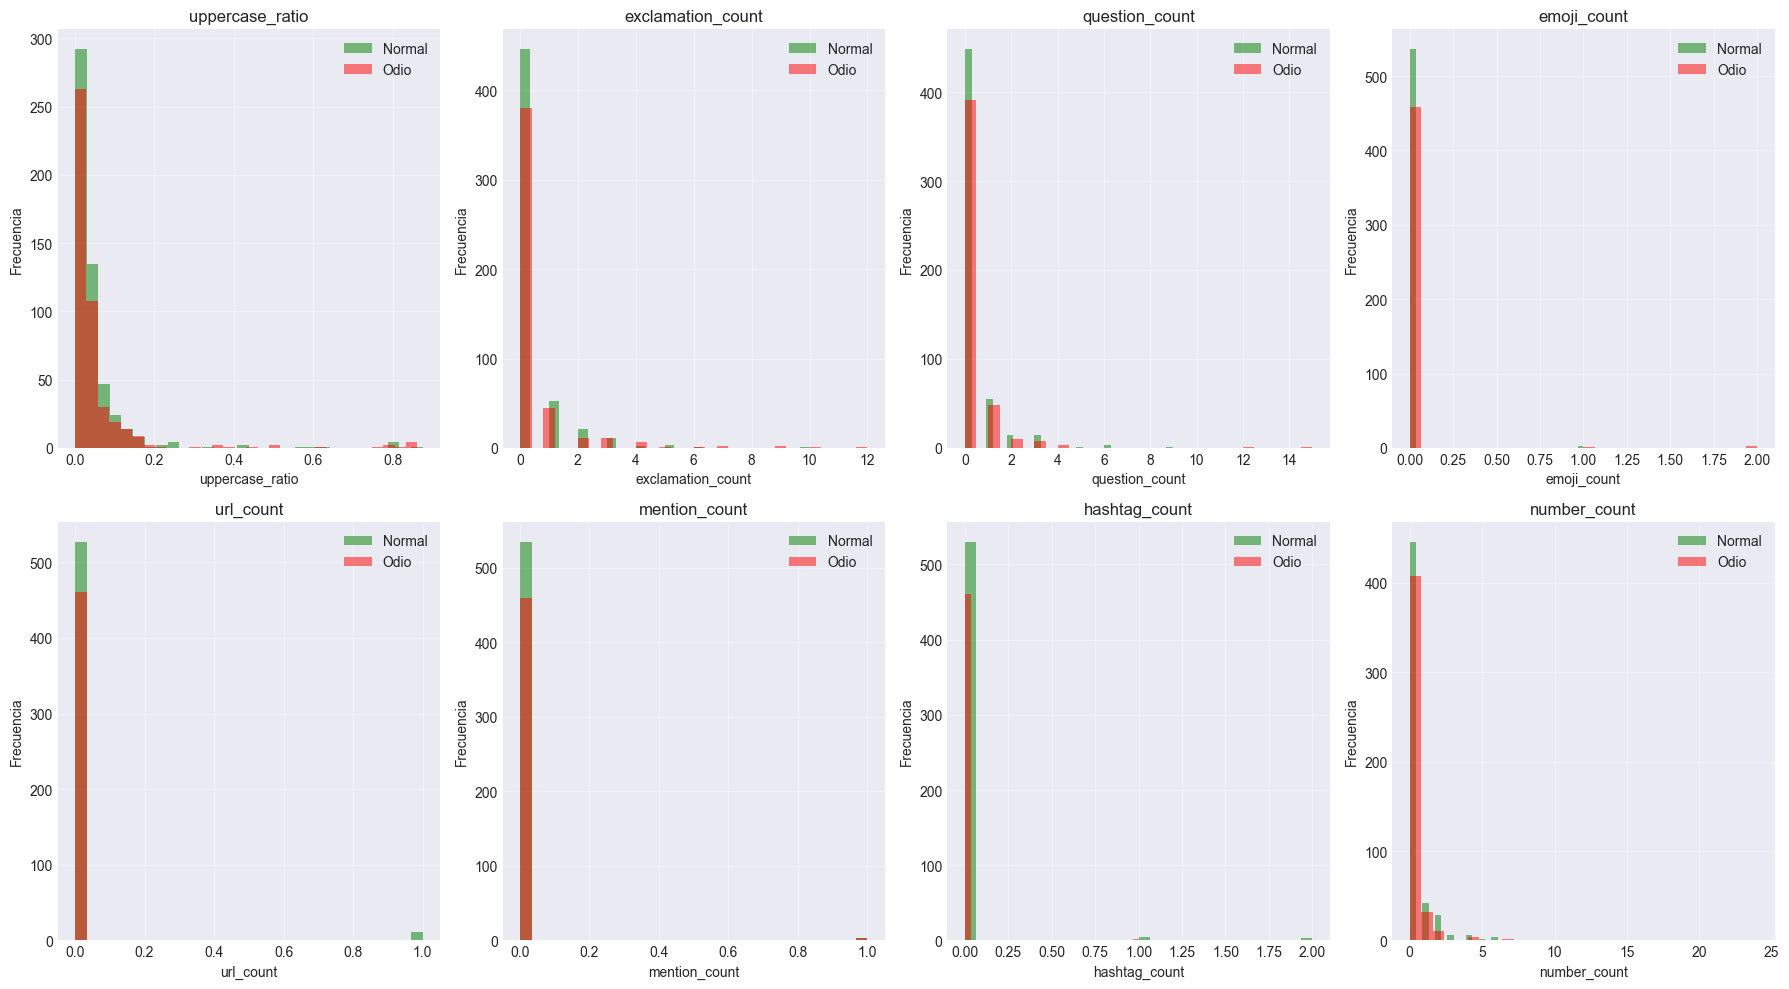

In [31]:
# =============================================================================
# 5. ANÁLISIS DE CARACTERES ESPECIALES
# =============================================================================

print("\n" + "="*80)
print("5. ANÁLISIS DE CARACTERES ESPECIALES")
print("="*80)

# Función para contar patrones
def count_pattern(text, pattern):
    return len(re.findall(pattern, str(text)))

# Crear features de caracteres especiales
df['uppercase_count'] = df['Text'].astype(str).apply(lambda x: sum(1 for c in x if c.isupper()))
df['uppercase_ratio'] = df['uppercase_count'] / df['char_count']
df['exclamation_count'] = df['Text'].astype(str).str.count('!')
df['question_count'] = df['Text'].astype(str).str.count(r'\?')
df['dots_count'] = df['Text'].astype(str).str.count(r'\.')
df['emoji_count'] = df['Text'].astype(str).apply(lambda x: count_pattern(x, r'[😀-🙏🌀-🗿🚀-🛿]'))
df['url_count'] = df['Text'].astype(str).apply(lambda x: count_pattern(x, r'http[s]?://'))
df['mention_count'] = df['Text'].astype(str).str.count('@')
df['hashtag_count'] = df['Text'].astype(str).str.count('#')
df['number_count'] = df['Text'].astype(str).apply(lambda x: count_pattern(x, r'\d+'))

special_char_cols = ['uppercase_ratio', 'exclamation_count', 'question_count', 
                     'emoji_count', 'url_count', 'mention_count', 'hashtag_count', 'number_count']

print(f"\n📊 CARACTERES ESPECIALES - COMPARATIVA:")
print(f"\n{'Feature':<25} {'Odio (Media)':>15} {'Normal (Media)':>15} {'Diferencia':>12}")
print("-" * 70)

for col in special_char_cols:
    hate_mean = df[df['IsHate'] == 1][col].mean()
    normal_mean = df[df['IsHate'] == 0][col].mean()
    diff = hate_mean - normal_mean
    print(f"{col:<25} {hate_mean:>15.4f} {normal_mean:>15.4f} {diff:>12.4f}")

# Visualización
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(special_char_cols):
    axes[idx].hist(df[df['IsHate'] == 0][col], bins=30, alpha=0.5, label='Normal', color='green')
    axes[idx].hist(df[df['IsHate'] == 1][col], bins=30, alpha=0.5, label='Odio', color='red')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].set_title(f'{col}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()



6. ANÁLISIS DE VOCABULARIO

📚 ESTADÍSTICAS DE VOCABULARIO:
   Total de palabras (tokens): 34,154
   Vocabulario único (types): 4,494
   Ratio Type/Token: 0.1316

   Palabras en mensajes de ODIO: 16,197
   Vocabulario único (odio): 2,897

   Palabras en mensajes NORMALES: 17,957
   Vocabulario único (normal): 3,054

🔝 TOP 30 PALABRAS MÁS FRECUENTES (GENERAL):
   the                     1,549 veces
   and                       818 veces
   to                        817 veces
   a                         791 veces
   of                        605 veces
   is                        541 veces
   that                      490 veces
   you                       489 veces
   i                         474 veces
   in                        440 veces
   this                      393 veces
   it                        347 veces
   are                       321 veces
   they                      280 veces
   was                       261 veces
   he                        260 veces
   people     

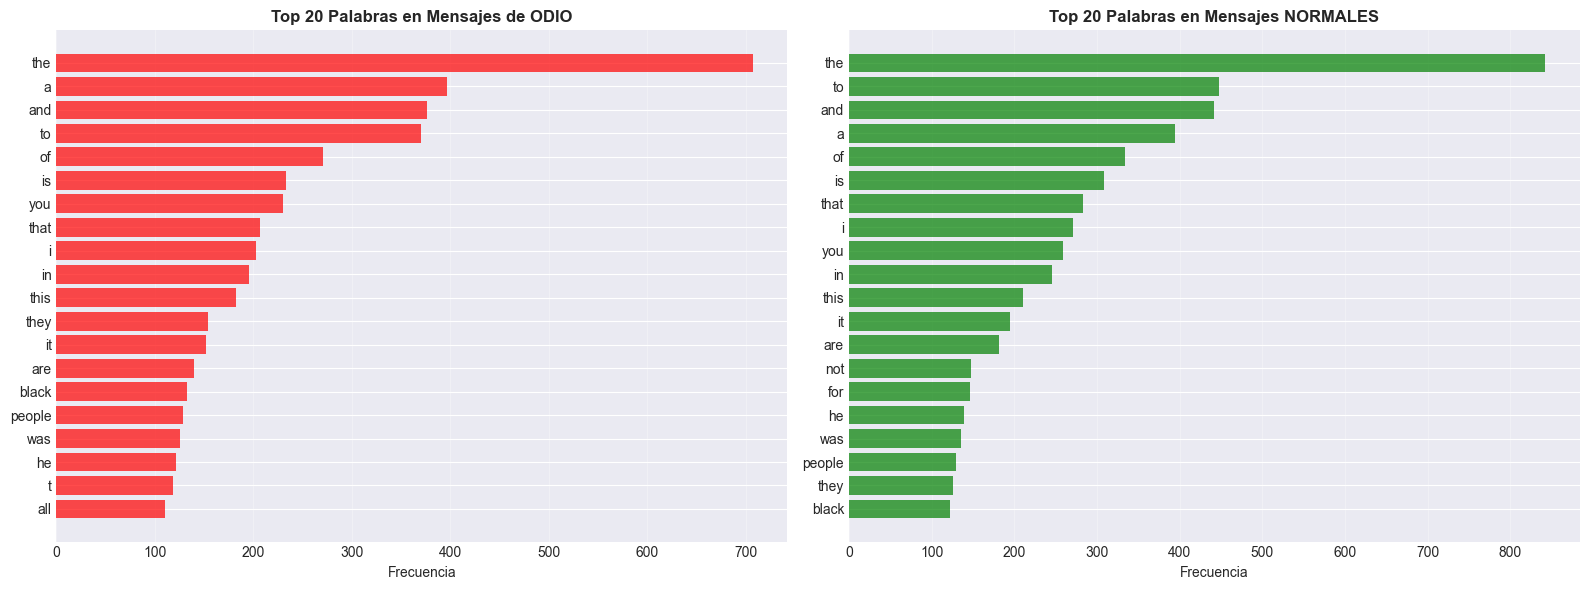

In [32]:
# =============================================================================
# 6. ANÁLISIS DE VOCABULARIO
# =============================================================================

print("\n" + "="*80)
print("6. ANÁLISIS DE VOCABULARIO")
print("="*80)

# Función para extraer palabras
def get_words(text):
    """Extrae palabras en minúsculas (sin preprocesar)"""
    return re.findall(r'\b[a-záéíóúñü]+\b', str(text).lower())

# Extraer todas las palabras
all_words = []
hate_words = []
normal_words = []

for idx, row in df.iterrows():
    words = get_words(row['Text'])
    all_words.extend(words)
    if row['IsHate'] == 1:
        hate_words.extend(words)
    else:
        normal_words.extend(words)

print(f"\n📚 ESTADÍSTICAS DE VOCABULARIO:")
print(f"   Total de palabras (tokens): {len(all_words):,}")
print(f"   Vocabulario único (types): {len(set(all_words)):,}")
print(f"   Ratio Type/Token: {len(set(all_words))/len(all_words):.4f}")
print(f"\n   Palabras en mensajes de ODIO: {len(hate_words):,}")
print(f"   Vocabulario único (odio): {len(set(hate_words)):,}")
print(f"\n   Palabras en mensajes NORMALES: {len(normal_words):,}")
print(f"   Vocabulario único (normal): {len(set(normal_words)):,}")

# Top palabras
print(f"\n🔝 TOP 30 PALABRAS MÁS FRECUENTES (GENERAL):")
word_freq = Counter(all_words)
for word, count in word_freq.most_common(30):
    print(f"   {word:<20} {count:>8,} veces")

print(f"\n🔥 TOP 30 PALABRAS EN MENSAJES DE ODIO:")
hate_freq = Counter(hate_words)
for word, count in hate_freq.most_common(30):
    pct = (count / len(hate_words)) * 100
    print(f"   {word:<20} {count:>8,} veces ({pct:.2f}%)")

print(f"\n✅ TOP 30 PALABRAS EN MENSAJES NORMALES:")
normal_freq = Counter(normal_words)
for word, count in normal_freq.most_common(30):
    pct = (count / len(normal_words)) * 100
    print(f"   {word:<20} {count:>8,} veces ({pct:.2f}%)")

# Palabras únicas de cada categoría
hate_only = set(hate_words) - set(normal_words)
normal_only = set(normal_words) - set(hate_words)

print(f"\n🎯 PALABRAS ÚNICAS DE MENSAJES DE ODIO: {len(hate_only):,}")
print(f"   Ejemplos (10 aleatorias): {list(hate_only)[:10]}")

print(f"\n🎯 PALABRAS ÚNICAS DE MENSAJES NORMALES: {len(normal_only):,}")
print(f"   Ejemplos (10 aleatorias): {list(normal_only)[:10]}")

# Visualización: Top palabras
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top palabras en odio
top_hate = hate_freq.most_common(20)
words_h, counts_h = zip(*top_hate)
axes[0].barh(range(len(words_h)), counts_h, color='red', alpha=0.7)
axes[0].set_yticks(range(len(words_h)))
axes[0].set_yticklabels(words_h)
axes[0].set_xlabel('Frecuencia')
axes[0].set_title('Top 20 Palabras en Mensajes de ODIO', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top palabras en normal
top_normal = normal_freq.most_common(20)
words_n, counts_n = zip(*top_normal)
axes[1].barh(range(len(words_n)), counts_n, color='green', alpha=0.7)
axes[1].set_yticks(range(len(words_n)))
axes[1].set_yticklabels(words_n)
axes[1].set_xlabel('Frecuencia')
axes[1].set_title('Top 20 Palabras en Mensajes NORMALES', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()


In [33]:
# =============================================================================
# 7. ANÁLISIS DE N-GRAMAS
# =============================================================================

print("\n" + "="*80)
print("7. ANÁLISIS DE N-GRAMAS")
print("="*80)

from collections import Counter

def get_ngrams(text, n=2):
    """Extrae n-gramas de un texto"""
    words = get_words(text)
    return list(zip(*[words[i:] for i in range(n)]))

# Bigramas
hate_bigrams = []
normal_bigrams = []

for idx, row in df.iterrows():
    bigrams = get_ngrams(row['Text'], n=2)
    if row['IsHate'] == 1:
        hate_bigrams.extend(bigrams)
    else:
        normal_bigrams.extend(bigrams)

print(f"\n📊 BIGRAMAS MÁS FRECUENTES EN MENSAJES DE ODIO:")
hate_bigram_freq = Counter(hate_bigrams)
for bigram, count in hate_bigram_freq.most_common(20):
    print(f"   {' '.join(bigram):<35} {count:>6,} veces")

print(f"\n📊 BIGRAMAS MÁS FRECUENTES EN MENSAJES NORMALES:")
normal_bigram_freq = Counter(normal_bigrams)
for bigram, count in normal_bigram_freq.most_common(20):
    print(f"   {' '.join(bigram):<35} {count:>6,} veces")

# Trigramas
hate_trigrams = []
normal_trigrams = []

for idx, row in df.iterrows():
    trigrams = get_ngrams(row['Text'], n=3)
    if row['IsHate'] == 1:
        hate_trigrams.extend(trigrams)
    else:
        normal_trigrams.extend(trigrams)

print(f"\n📊 TRIGRAMAS MÁS FRECUENTES EN MENSAJES DE ODIO:")
hate_trigram_freq = Counter(hate_trigrams)
for trigram, count in hate_trigram_freq.most_common(15):
    print(f"   {' '.join(trigram):<40} {count:>6,} veces")


7. ANÁLISIS DE N-GRAMAS

📊 BIGRAMAS MÁS FRECUENTES EN MENSAJES DE ODIO:
   in the                                  67 veces
   of the                                  45 veces
   don t                                   44 veces
   black people                            32 veces
   the police                              30 veces
   is a                                    28 veces
   it s                                    28 veces
   on the                                  27 veces
   if you                                  27 veces
   to the                                  26 veces
   out of                                  24 veces
   to be                                   23 veces
   for the                                 21 veces
   was a                                   21 veces
   this is                                 21 veces
   have to                                 20 veces
   he was                                  20 veces
   can t                                   

In [34]:
# =============================================================================
# 8. ANÁLISIS DE VÍDEOS
# =============================================================================

print("\n" + "="*80)
print("8. ANÁLISIS DE VIDEOS")
print("="*80)

print(f"\n📹 ESTADÍSTICAS DE VIDEOS:")
print(f"   Videos únicos en el dataset: {df['VideoId'].nunique():,}")
print(f"   Comentarios por video (promedio): {df.groupby('VideoId').size().mean():.2f}")
print(f"   Comentarios por video (mediana): {df.groupby('VideoId').size().median():.0f}")
print(f"   Comentarios por video (máximo): {df.groupby('VideoId').size().max():,}")
print(f"   Comentarios por video (mínimo): {df.groupby('VideoId').size().min():,}")

print(f"\n🔥 TOP 10 VIDEOS CON MÁS COMENTARIOS:")
video_comments = df['VideoId'].value_counts().head(10)
for video_id, count in video_comments.items():
    hate_count_video = df[(df['VideoId'] == video_id) & (df['IsHate'] == 1)].shape[0]
    hate_pct = (hate_count_video / count) * 100
    print(f"   {video_id}: {count:>5,} comentarios ({hate_count_video:>4,} odio, {hate_pct:>5.1f}%)")

print(f"\n🔥 TOP 10 VIDEOS CON MAYOR % DE MENSAJES DE ODIO (mín. 10 comentarios):")
video_stats = df.groupby('VideoId').agg({
    'IsHate': ['sum', 'count']
}).reset_index()
video_stats.columns = ['VideoId', 'hate_count', 'total_count']
video_stats = video_stats[video_stats['total_count'] >= 10]
video_stats['hate_pct'] = (video_stats['hate_count'] / video_stats['total_count']) * 100
video_stats = video_stats.sort_values('hate_pct', ascending=False)

for idx, row in video_stats.head(10).iterrows():
    print(f"   {row['VideoId']}: {row['hate_pct']:.1f}% odio ({row['hate_count']:.0f}/{row['total_count']:.0f} comentarios)")



8. ANÁLISIS DE VIDEOS

📹 ESTADÍSTICAS DE VIDEOS:
   Videos únicos en el dataset: 13
   Comentarios por video (promedio): 76.92
   Comentarios por video (mediana): 38
   Comentarios por video (máximo): 274
   Comentarios por video (mínimo): 8

🔥 TOP 10 VIDEOS CON MÁS COMENTARIOS:
   9pr1oE34bIM:   274 comentarios (  88 odio,  32.1%)
   04kJtp6pVXI:   172 comentarios ( 111 odio,  64.5%)
   cT14IbTDW2c:   146 comentarios ( 108 odio,  74.0%)
   dG7mZQvaQDk:   112 comentarios (  22 odio,  19.6%)
   TZxEyoplYbI:   104 comentarios (  50 odio,  48.1%)
   bUgKZMSxr3E:    39 comentarios (  18 odio,  46.2%)
   8HB18hZrhXc:    38 comentarios (  23 odio,  60.5%)
   4rCweDxDqdw:    37 comentarios (  10 odio,  27.0%)
   Dt9-byUhPdg:    34 comentarios (  17 odio,  50.0%)
   #NAME?:    16 comentarios (   5 odio,  31.2%)

🔥 TOP 10 VIDEOS CON MAYOR % DE MENSAJES DE ODIO (mín. 10 comentarios):
   cT14IbTDW2c: 74.0% odio (108/146 comentarios)
   04kJtp6pVXI: 64.5% odio (111/172 comentarios)
   8HB18hZrhXc

In [35]:
# =============================================================================
# 10. RESUMEN Y CONCLUSIONES
# =============================================================================

print("\n" + "="*80)
print("10. RESUMEN EJECUTIVO Y CONCLUSIONES")
print("="*80)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        RESUMEN EJECUTIVO - EDA                               ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 TAMAÑO DEL DATASET:
   • Total de comentarios: {len(df):,}
   • Videos únicos: {df['VideoId'].nunique():,}
   • Comentarios únicos: {len(df) - df['Text'].duplicated().sum():,}

🎯 DISTRIBUCIÓN DE CLASES:
   • Mensajes de ODIO: {hate_count:,} ({(hate_count/len(df)*100):.2f}%)
   • Mensajes NORMALES: {no_hate_count:,} ({(no_hate_count/len(df)*100):.2f}%)
   • Ratio de desbalanceo: 1:{(no_hate_count/hate_count):.2f}
   ⚠️  PROBLEMA: Dataset {'DESBALANCEADO' if (no_hate_count/hate_count) > 3 else 'relativamente balanceado'}

📏 LONGITUD DE COMENTARIOS:
   • Promedio de caracteres (Odio): {df[df['IsHate']==1]['char_count'].mean():.0f}
   • Promedio de caracteres (Normal): {df[df['IsHate']==0]['char_count'].mean():.0f}
   • Promedio de palabras (Odio): {df[df['IsHate']==1]['word_count'].mean():.0f}
   • Promedio de palabras (Normal): {df[df['IsHate']==0]['word_count'].mean():.0f}
   ⚠️  PROBLEMA: Comentarios {'EXTENSOS' if df['char_count'].mean() > 500 else 'moderados'}

🔥 TIPOS DE ODIO MÁS FRECUENTES:
""")

for col in label_columns[:5]:
    count = df[col].sum()
    pct = (count / len(df)) * 100
    print(f"   • {col.replace('Is', '')}: {count:,} ({pct:.2f}%)")

print(f"""
✅ CALIDAD DE DATOS:
   • Valores nulos: {df.isnull().sum().sum():,}
   • Duplicados completos: {duplicados:,}
   • Duplicados de texto: {duplicados_texto:,}
   {'⚠️  ADVERTENCIA: Hay valores nulos o duplicados que requieren atención' if (df.isnull().sum().sum() > 0 or duplicados > 0) else '✅ Datos sin nulos ni duplicados'}

📚 VOCABULARIO:
   • Total de palabras: {len(all_words):,}
   • Vocabulario único: {len(set(all_words)):,}
   • Palabras únicas en odio: {len(hate_only):,}
   • Palabras únicas en normal: {len(normal_only):,}

╔══════════════════════════════════════════════════════════════════════════════╗
║                     PRINCIPALES HALLAZGOS                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. 🔴 DESBALANCEO DE CLASES
   El dataset está {'muy ' if (no_hate_count/hate_count) > 5 else ''}desbalanceado.
   → Recomendación: Usar técnicas de balanceo (SMOTE, class_weights, undersampling)
   → Métrica principal: F1-Score o ROC-AUC (no accuracy)

2. 📏 LONGITUD DE COMENTARIOS
   Los comentarios son {'extensos' if df['char_count'].mean() > 500 else 'moderados en longitud'}.
   → Recomendación: Considerar técnicas de truncamiento o modelos que manejen secuencias largas
   → Probar con max_length en tokenización (256, 512 tokens)

3. 🔤 CARACTERÍSTICAS DISTINTIVAS
   Los mensajes de odio tienen:
   → {'Mayor' if df[df['IsHate']==1]['uppercase_ratio'].mean() > df[df['IsHate']==0]['uppercase_ratio'].mean() else 'Menor'} uso de MAYÚSCULAS
   → {'Más' if df[df['IsHate']==1]['exclamation_count'].mean() > df[df['IsHate']==0]['exclamation_count'].mean() else 'Menos'} signos de exclamación
   → Vocabulario específico identificable

4. 🎯 MULTI-LABEL PROBLEM
   • {df[df['num_labels'] > 1].shape[0]:,} comentarios tienen múltiples etiquetas
   → Considerar: enfoque multi-label vs. binary (odio sí/no)
   → Probar: Binary Relevance, Classifier Chains, o Label Powerset

5. 📹 VIDEOS PROBLEMÁTICOS
   Algunos videos concentran más mensajes de odio
   → Oportunidad: Feature engineering con VideoId
   → Posible: Análisis por tipo de contenido del video

╔══════════════════════════════════════════════════════════════════════════════╗
║                     RECOMENDACIONES PARA PREPROCESAMIENTO                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

📋 PIPELINE SUGERIDO:

1. LIMPIEZA BÁSICA:
   ✓ Eliminar valores nulos y duplicados
   ✓ Normalizar espacios en blanco
   ✓ Manejar comentarios vacíos

2. NORMALIZACIÓN DE TEXTO:
   ✓ Convertir a minúsculas (EXCEPTO si mayúsculas son feature)
   ✓ Eliminar o normalizar URLs, menciones (@), hashtags
   ✓ Decidir qué hacer con emojis (eliminar, convertir a texto, o mantener)
   ✓ Manejar números (eliminar o reemplazar por token especial)

3. TOKENIZACIÓN Y STOPWORDS:
   ✓ Usar tokenizador apropiado para español
   ✓ Remover stopwords PERO con cuidado (algunas pueden ser relevantes)
   ✓ Aplicar stemming O lematización (probar ambos)

4. FEATURES ADICIONALES:
   ✓ Mantener features numéricas: longitud, mayúsculas, signos
   ✓ TF-IDF con diferentes configuraciones de n-gramas
   ✓ Word embeddings (Word2Vec, FastText, o BERT en español)

5. BALANCEO:
   ✓ SMOTE para datos textuales (con vectorización previa)
   ✓ Class weights en el modelo
   ✓ Undersampling de clase mayoritaria

╔══════════════════════════════════════════════════════════════════════════════╗
║                     SIGUIENTES PASOS                                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. 🧹 PREPROCESAMIENTO
   → Notebook: 02_preprocesamiento.ipynb

2. 🔤 VECTORIZACIÓN
   → Probar: BoW, TF-IDF, Word2Vec, BERT embeddings

3. 🤖 MODELADO
   → Baseline: Logistic Regression, Naive Bayes
   → Avanzado: Random Forest, XGBoost, SVM
   → Deep Learning: LSTM, BERT fine-tuning

4. 📊 EVALUACIÓN
   → Métricas: Precision, Recall, F1-Score, ROC-AUC
   → Confusion Matrix por cada tipo de odio
   → Análisis de errores

5. 🚀 PRODUCTIVIZACIÓN
   → API con FastAPI
   → Interfaz con Streamlit
   → Dockerización

╔══════════════════════════════════════════════════════════════════════════════╗
║                     ADVERTENCIAS IMPORTANTES                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

⚠️  COMENTARIOS EXTENSOS:
    Los comentarios muy largos pueden ser un problema para modelos tradicionales.
    Soluciones: Truncar, usar modelos que manejen secuencias largas, o dividir.

⚠️  DESBALANCEO:
    No usar accuracy como métrica principal.
    Enfocarse en recall (no dejar pasar mensajes de odio).

⚠️  MULTI-LABEL:
    Decidir si entrenar un modelo por tipo de odio o uno general.
    Considerar jerarquías: ToxicDetection → ThreatDetection, etc.

⚠️  IDIOMA:
    Asegurar que modelos y stopwords sean para ESPAÑOL.
    Considerar modelos pre-entrenados en español (BETO, RoBERTuito).

""")

print("="*80)
print("✅ EDA COMPLETADO")
print("="*80)




10. RESUMEN EJECUTIVO Y CONCLUSIONES

╔══════════════════════════════════════════════════════════════════════════════╗
║                        RESUMEN EJECUTIVO - EDA                               ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 TAMAÑO DEL DATASET:
   • Total de comentarios: 1,000
   • Videos únicos: 13
   • Comentarios únicos: 997

🎯 DISTRIBUCIÓN DE CLASES:
   • Mensajes de ODIO: 462 (46.20%)
   • Mensajes NORMALES: 538 (53.80%)
   • Ratio de desbalanceo: 1:1.16
   ⚠️  PROBLEMA: Dataset relativamente balanceado

📏 LONGITUD DE COMENTARIOS:
   • Promedio de caracteres (Odio): 189
   • Promedio de caracteres (Normal): 182
   • Promedio de palabras (Odio): 35
   • Promedio de palabras (Normal): 33
   ⚠️  PROBLEMA: Comentarios moderados

🔥 TIPOS DE ODIO MÁS FRECUENTES:

   • Toxic: 462 (46.20%)
   • Abusive: 353 (35.30%)
   • Threat: 21 (2.10%)
   • Provocative: 161 (16.10%)
   • Obscene: 100 (10.00%)



✅ CALIDAD DE DATOS:
   • Valores nulos: 0
   • Duplicados completos: 0
   • Duplicados de texto: 3
   ✅ Datos sin nulos ni duplicados

📚 VOCABULARIO:
   • Total de palabras: 34,154
   • Vocabulario único: 4,494
   • Palabras únicas en odio: 1,440
   • Palabras únicas en normal: 1,597

╔══════════════════════════════════════════════════════════════════════════════╗
║                     PRINCIPALES HALLAZGOS                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. 🔴 DESBALANCEO DE CLASES
   El dataset está desbalanceado.
   → Recomendación: Usar técnicas de balanceo (SMOTE, class_weights, undersampling)
   → Métrica principal: F1-Score o ROC-AUC (no accuracy)

2. 📏 LONGITUD DE COMENTARIOS
   Los comentarios son moderados en longitud.
   → Recomendación: Considerar técnicas de truncamiento o modelos que manejen secuencias largas
   → Probar con max_length en tokenización (256, 512 tokens)

3. 🔤 CARACTERÍSTICAS DISTINTIVAS


PREPROCESAMIENTO

In [36]:
import string


# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("✅ Librerías importadas correctamente")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...


✅ Librerías importadas correctamente


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [37]:
# =============================================================================
# 1. ELIMINACIÓN DE DUPLICADOS
# =============================================================================

print("="*80)
print("1. ELIMINACIÓN DE DUPLICADOS")
print("="*80)

print(f"\n📊 ANTES DE LIMPIAR:")
print(f"   Total de comentarios: {len(df):,}")
print(f"   Comentarios duplicados (texto): {df['Text'].duplicated().sum()}")

# Mostrar duplicados
if df['Text'].duplicated().sum() > 0:
    print(f"\n🔍 COMENTARIOS DUPLICADOS:")
    duplicados = df[df['Text'].duplicated(keep=False)].sort_values('Text')
    print(duplicados[['Text', 'IsHate', 'IsToxic']].head(10))
    
    # Eliminar duplicados manteniendo el primero
    df_clean = df.drop_duplicates(subset=['Text'], keep='first').copy()
    
    print(f"\n✅ DESPUÉS DE LIMPIAR:")
    print(f"   Total de comentarios: {len(df_clean):,}")
    print(f"   Comentarios eliminados: {len(df) - len(df_clean)}")
else:
    df_clean = df.copy()
    print("\n✅ No hay duplicados que eliminar")

1. ELIMINACIÓN DE DUPLICADOS

📊 ANTES DE LIMPIAR:
   Total de comentarios: 1,000
   Comentarios duplicados (texto): 3

🔍 COMENTARIOS DUPLICADOS:
              Text  IsHate  IsToxic
592  RUN THEM OVER    True     True
699  RUN THEM OVER    True     True
642  run them over    True     True
657  run them over    True     True
677  run them over    True     True

✅ DESPUÉS DE LIMPIAR:
   Total de comentarios: 997
   Comentarios eliminados: 3


In [38]:
# =============================================================================
# 2. FUNCIONES DE PREPROCESAMIENTO
# =============================================================================

print("\n" + "="*80)
print("2. DEFINICIÓN DE FUNCIONES DE LIMPIEZA")
print("="*80)

def clean_text_basic(text):
    """
    Limpieza básica del texto
    - Elimina URLs
    - Elimina menciones (@usuario)
    - Elimina hashtags (#)
    - Elimina saltos de línea y tabs
    """
    # Convertir a string por si acaso
    text = str(text)
    
    # Eliminar URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Eliminar menciones
    text = re.sub(r'@\w+', '', text)
    
    # Eliminar hashtags (mantener el texto después del #)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Eliminar saltos de línea y tabs
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


def clean_text_advanced(text, remove_numbers=True, remove_punctuation=False, lowercase=True):
    """
    Limpieza avanzada del texto
    """
    text = str(text)
    
    # Convertir a minúsculas (opcional)
    if lowercase:
        text = text.lower()
    
    # Eliminar números (opcional)
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    
    # Eliminar puntuación (opcional)
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


def remove_stopwords(text, language='english'):
    """
    Elimina stopwords en inglés
    """
    stop_words = set(stopwords.words(language))
    words = text.split()
    
    # Filtrar stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_words)


def apply_stemming(text):
    """
    Aplica stemming (PorterStemmer)
    """
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)


def apply_lemmatization(text):
    """
    Aplica lematización
    """
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

print("✅ Funciones definidas correctamente")


2. DEFINICIÓN DE FUNCIONES DE LIMPIEZA
✅ Funciones definidas correctamente


In [39]:
# =============================================================================
# 3. APLICAR LIMPIEZA BÁSICA
# =============================================================================

print("\n" + "="*80)
print("3. LIMPIEZA BÁSICA DEL TEXTO")
print("="*80)

# Crear columna con texto original limpio
df_clean['Text_Clean_Basic'] = df_clean['Text'].apply(clean_text_basic)

# Comparar antes y después
print("\n🔍 EJEMPLOS DE LIMPIEZA BÁSICA:\n")
for i in range(5):
    print(f"ORIGINAL [{i+1}]:")
    print(f"   {df_clean['Text'].iloc[i][:150]}...")
    print(f"\nLIMPIO [{i+1}]:")
    print(f"   {df_clean['Text_Clean_Basic'].iloc[i][:150]}...")
    print("-" * 80)

# Verificar longitud después de limpieza
df_clean['char_count_clean'] = df_clean['Text_Clean_Basic'].str.len()
df_clean['word_count_clean'] = df_clean['Text_Clean_Basic'].str.split().str.len()

print("\n📊 ESTADÍSTICAS DESPUÉS DE LIMPIEZA BÁSICA:")
print(f"   Promedio caracteres (antes): {df_clean['char_count'].mean():.2f}")
print(f"   Promedio caracteres (después): {df_clean['char_count_clean'].mean():.2f}")
print(f"   Promedio palabras (antes): {df_clean['word_count'].mean():.2f}")
print(f"   Promedio palabras (después): {df_clean['word_count_clean'].mean():.2f}")


3. LIMPIEZA BÁSICA DEL TEXTO

🔍 EJEMPLOS DE LIMPIEZA BÁSICA:

ORIGINAL [1]:
   If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation. ...

LIMPIO [1]:
   If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation. ...
--------------------------------------------------------------------------------
ORIGINAL [2]:
   Law enforcement is not trained to shoot to apprehend.  They are trained to shoot to kill.  And I thank Wilson for killing that punk bitch....

LIMPIO [2]:
   Law enforcement is not trained to shoot to apprehend. They are trained to shoot to kill. And I thank Wilson for killing that punk bitch....
--------------------------------------------------------------------------------
ORIGINAL [3]:
   
Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and

In [40]:
# =============================================================================
# 4. NORMALIZACIÓN AVANZADA
# =============================================================================

print("\n" + "="*80)
print("4. NORMALIZACIÓN AVANZADA")
print("="*80)

# Aplicar limpieza avanzada (lowercase, sin números, CON puntuación)
df_clean['Text_Clean_Advanced'] = df_clean['Text_Clean_Basic'].apply(
    lambda x: clean_text_advanced(x, remove_numbers=True, remove_punctuation=False, lowercase=True)
)

print("\n🔍 EJEMPLOS DE LIMPIEZA AVANZADA:\n")
for i in range(3):
    print(f"BÁSICO [{i+1}]:")
    print(f"   {df_clean['Text_Clean_Basic'].iloc[i][:120]}...")
    print(f"\nAVANZADO [{i+1}]:")
    print(f"   {df_clean['Text_Clean_Advanced'].iloc[i][:120]}...")
    print("-" * 80)


4. NORMALIZACIÓN AVANZADA

🔍 EJEMPLOS DE LIMPIEZA AVANZADA:

BÁSICO [1]:
   If only people would just take a step back and not make this case about them, because it wasn't about anyone except the ...

AVANZADO [1]:
   if only people would just take a step back and not make this case about them, because it wasn't about anyone except the ...
--------------------------------------------------------------------------------
BÁSICO [2]:
   Law enforcement is not trained to shoot to apprehend. They are trained to shoot to kill. And I thank Wilson for killing ...

AVANZADO [2]:
   law enforcement is not trained to shoot to apprehend. they are trained to shoot to kill. and i thank wilson for killing ...
--------------------------------------------------------------------------------
BÁSICO [3]:
   Dont you reckon them 'black lives matter' banners being held by white cunts is kinda patronizing and ironically racist. ...

AVANZADO [3]:
   dont you reckon them 'black lives matter' banners being h

In [41]:
# =============================================================================
# 5. ELIMINACIÓN DE STOPWORDS
# =============================================================================

print("\n" + "="*80)
print("5. ELIMINACIÓN DE STOPWORDS")
print("="*80)

# Aplicar eliminación de stopwords
df_clean['Text_No_Stopwords'] = df_clean['Text_Clean_Advanced'].apply(remove_stopwords)

# Verificar cuántas palabras se eliminaron
df_clean['word_count_no_stop'] = df_clean['Text_No_Stopwords'].str.split().str.len()

print(f"\n📊 IMPACTO DE REMOVER STOPWORDS:")
print(f"   Promedio palabras (antes): {df_clean['word_count_clean'].mean():.2f}")
print(f"   Promedio palabras (después): {df_clean['word_count_no_stop'].mean():.2f}")
print(f"   Reducción promedio: {(df_clean['word_count_clean'].mean() - df_clean['word_count_no_stop'].mean()):.2f} palabras ({((df_clean['word_count_clean'].mean() - df_clean['word_count_no_stop'].mean()) / df_clean['word_count_clean'].mean() * 100):.1f}%)")

print("\n🔍 EJEMPLOS SIN STOPWORDS:\n")
for i in range(3):
    print(f"CON STOPWORDS [{i+1}]:")
    print(f"   {df_clean['Text_Clean_Advanced'].iloc[i][:120]}...")
    print(f"\nSIN STOPWORDS [{i+1}]:")
    print(f"   {df_clean['Text_No_Stopwords'].iloc[i][:120]}...")
    print("-" * 80)

# Mostrar stopwords en inglés
stop_words = stopwords.words('english')
print(f"\n📚 STOPWORDS EN INGLÉS ({len(stop_words)} palabras):")
print(f"   Ejemplos: {stop_words[:20]}")


5. ELIMINACIÓN DE STOPWORDS

📊 IMPACTO DE REMOVER STOPWORDS:
   Promedio palabras (antes): 33.86
   Promedio palabras (después): 17.98
   Reducción promedio: 15.87 palabras (46.9%)

🔍 EJEMPLOS SIN STOPWORDS:

CON STOPWORDS [1]:
   if only people would just take a step back and not make this case about them, because it wasn't about anyone except the ...

SIN STOPWORDS [1]:
   people would take step back make case them, anyone except two people situation. lump mess take matters hands makes kinds...
--------------------------------------------------------------------------------
CON STOPWORDS [2]:
   law enforcement is not trained to shoot to apprehend. they are trained to shoot to kill. and i thank wilson for killing ...

SIN STOPWORDS [2]:
   law enforcement trained shoot apprehend. trained shoot kill. thank wilson killing punk bitch....
--------------------------------------------------------------------------------
CON STOPWORDS [3]:
   dont you reckon them 'black lives matter' banne

In [42]:
# =============================================================================
# 6. STEMMING vs LEMMATIZATION
# =============================================================================

print("\n" + "="*80)
print("6. STEMMING vs LEMMATIZATION")
print("="*80)

# Aplicar stemming
print("\n⏳ Aplicando STEMMING...")
df_clean['Text_Stemmed'] = df_clean['Text_No_Stopwords'].apply(apply_stemming)

# Aplicar lemmatización
print("⏳ Aplicando LEMMATIZATION...")
df_clean['Text_Lemmatized'] = df_clean['Text_No_Stopwords'].apply(apply_lemmatization)

print("\n✅ Completado\n")

# Comparar diferencias
print("🔍 COMPARACIÓN: Original vs Stemming vs Lemmatization\n")
for i in range(3):
    print(f"EJEMPLO {i+1}:")
    print(f"   SIN STOPWORDS: {df_clean['Text_No_Stopwords'].iloc[i][:100]}...")
    print(f"   STEMMED:       {df_clean['Text_Stemmed'].iloc[i][:100]}...")
    print(f"   LEMMATIZED:    {df_clean['Text_Lemmatized'].iloc[i][:100]}...")
    print("-" * 80)

# Ejemplo específico para entender la diferencia
ejemplo_texto = "running runs runner ran easily fairly"
print(f"\n📖 EJEMPLO DIDÁCTICO:")
print(f"   Original:    {ejemplo_texto}")
print(f"   Stemmed:     {apply_stemming(ejemplo_texto)}")
print(f"   Lemmatized:  {apply_lemmatization(ejemplo_texto)}")


6. STEMMING vs LEMMATIZATION

⏳ Aplicando STEMMING...
⏳ Aplicando LEMMATIZATION...

✅ Completado

🔍 COMPARACIÓN: Original vs Stemming vs Lemmatization

EJEMPLO 1:
   SIN STOPWORDS: people would take step back make case them, anyone except two people situation. lump mess take matte...
   STEMMED:       peopl would take step back make case them, anyon except two peopl situation. lump mess take matter h...
   LEMMATIZED:    people would take step back make case them, anyone except two people situation. lump mess take matte...
--------------------------------------------------------------------------------
EJEMPLO 2:
   SIN STOPWORDS: law enforcement trained shoot apprehend. trained shoot kill. thank wilson killing punk bitch....
   STEMMED:       law enforc train shoot apprehend. train shoot kill. thank wilson kill punk bitch....
   LEMMATIZED:    law enforcement trained shoot apprehend. trained shoot kill. thank wilson killing punk bitch....
---------------------------------------------

In [43]:
# =============================================================================
# 7. COMPARACIÓN DE TODAS LAS VERSIONES
# =============================================================================

print("\n" + "="*80)
print("7. RESUMEN: COMPARACIÓN DE TODAS LAS VERSIONES")
print("="*80)

versiones = {
    'Original': 'Text',
    'Básico': 'Text_Clean_Basic',
    'Avanzado': 'Text_Clean_Advanced',
    'Sin Stopwords': 'Text_No_Stopwords',
    'Stemmed': 'Text_Stemmed',
    'Lemmatized': 'Text_Lemmatized'
}

print("\n📊 ESTADÍSTICAS POR VERSIÓN:\n")
print(f"{'Versión':<20} {'Chars (Avg)':>15} {'Words (Avg)':>15} {'Vocab Único':>15}")
print("-" * 70)

for nombre, columna in versiones.items():
    avg_chars = df_clean[columna].astype(str).str.len().mean()
    avg_words = df_clean[columna].astype(str).str.split().str.len().mean()
    
    # Vocabulario único
    all_words = ' '.join(df_clean[columna].astype(str)).split()
    vocab_unico = len(set(all_words))
    
    print(f"{nombre:<20} {avg_chars:>15.2f} {avg_words:>15.2f} {vocab_unico:>15,}")

# Mostrar un ejemplo completo
print("\n\n🔍 EJEMPLO COMPLETO DE TODAS LAS TRANSFORMACIONES:")
print("=" * 80)
idx = 2  # Cambia este índice para ver otros ejemplos

for nombre, columna in versiones.items():
    print(f"\n{nombre.upper()}:")
    print(f"   {df_clean[columna].iloc[idx]}")
    print("-" * 80)


7. RESUMEN: COMPARACIÓN DE TODAS LAS VERSIONES

📊 ESTADÍSTICAS POR VERSIÓN:

Versión                  Chars (Avg)     Words (Avg)     Vocab Único
----------------------------------------------------------------------
Original                      186.07           33.87           7,537
Básico                        184.43           33.86           7,522
Avanzado                      183.75           33.74           6,543
Sin Stopwords                 121.44           17.98           6,390
Stemmed                       110.85           17.98           5,496
Lemmatized                    119.89           17.98           6,080


🔍 EJEMPLO COMPLETO DE TODAS LAS TRANSFORMACIONES:

ORIGINAL:
   
Dont you reckon them 'black lives matter' banners being held by white cunts is  kinda patronizing and ironically racist. could they have not come up with somethin better.. or is it just what white folks do to give them selves pride. 'ooo look at me im being nice for the black people' why does it alwa

In [44]:
# =============================================================================
# 8. SELECCIÓN DE VERSIÓN FINAL Y GUARDADO
# =============================================================================

print("\n" + "="*80)
print("8. SELECCIÓN DE VERSIÓN FINAL")
print("="*80)

# Crear diferentes versiones para modelado
print("\n📦 CREANDO DATASETS PARA MODELADO:\n")

# Versión 1: Con stopwords + Lemmatized (más información, menos ruido que stemming)
df_version1 = df_clean[['CommentId', 'VideoId', 'Text', 'Text_Clean_Advanced', 
                        'IsHate', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
                        'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist',
                        'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']].copy()
df_version1.rename(columns={'Text_Clean_Advanced': 'Text_Processed'}, inplace=True)

# Versión 2: Sin stopwords + Lemmatized (menos ruido, más enfoque en palabras clave)
df_version2 = df_clean[['CommentId', 'VideoId', 'Text', 'Text_Lemmatized',
                        'IsHate', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
                        'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist',
                        'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']].copy()
df_version2.rename(columns={'Text_Lemmatized': 'Text_Processed'}, inplace=True)

# Versión 3: Sin stopwords + Stemmed (más agresivo, puede perder semántica)
df_version3 = df_clean[['CommentId', 'VideoId', 'Text', 'Text_Stemmed',
                        'IsHate', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
                        'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist',
                        'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']].copy()
df_version3.rename(columns={'Text_Stemmed': 'Text_Processed'}, inplace=True)




8. SELECCIÓN DE VERSIÓN FINAL

📦 CREANDO DATASETS PARA MODELADO:



In [45]:
# =============================================================================
# 9. RESUMEN FINAL DE PREPROCESAMIENTO
# =============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL - PREPROCESAMIENTO COMPLETADO")
print("="*80)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                   PREPROCESAMIENTO COMPLETADO                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASET ORIGINAL:
   • Comentarios: {len(df):,}
   • Duplicados eliminados: {len(df) - len(df_clean)}

✅ TRANSFORMACIONES APLICADAS:
   1. ✓ Eliminación de URLs, menciones y hashtags
   2. ✓ Normalización de espacios y saltos de línea
   3. ✓ Conversión a minúsculas
   4. ✓ Eliminación de números
   5. ✓ Eliminación de stopwords (opcional)
   6. ✓ Stemming (agresivo)
   7. ✓ Lemmatization (conservador)

📦 VERSIONES GENERADAS:
   • Versión 1: Con stopwords (más contexto)
   • Versión 2: Lemmatized sin stopwords (RECOMENDADA)
   • Versión 3: Stemmed sin stopwords (vocabulario reducido)

🎯 PRÓXIMOS PASOS:
   1. Vectorización (TF-IDF, CountVectorizer, Word2Vec)
   2. Feature Engineering (agregar features numéricas)
   3. Modelado (Baseline → Avanzado → Deep Learning)
   4. Evaluación y ajuste de hiperparámetros

╔══════════════════════════════════════════════════════════════════════════════╗
║                      RECOMENDACIONES                                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

💡 PARA MODELADO CLÁSICO (Logistic Regression, Naive Bayes, SVM):
   → Usar Versión 2 (Lemmatized) con TF-IDF
   → Agregar n-gramas (bigrams, trigrams)
   → Incluir features numéricas del EDA

💡 PARA MODELOS DE ENSEMBLE (Random Forest, XGBoost):
   → Combinar TF-IDF + features numéricas
   → Probar diferentes max_features
   → Usar class_weight para desbalanceo

💡 PARA DEEP LEARNING (LSTM, BERT):
   → Usar Versión 1 (con stopwords, más contexto)
   → Considerar embeddings pre-entrenados (GloVe, Word2Vec)
   → Fine-tuning de BERT para inglés

⚠️  ADVERTENCIAS:
   • El dataset tiene solo 1,000 comentarios → modelos simples pueden funcionar mejor
   • Desbalanceo leve (46% odio) → usar F1-Score, no accuracy
   • Multi-label → decidir entre binary classification o multi-label approach
""")

print("="*80)
print("✅ PREPROCESAMIENTO FINALIZADO")
print("="*80)


RESUMEN FINAL - PREPROCESAMIENTO COMPLETADO

╔══════════════════════════════════════════════════════════════════════════════╗
║                   PREPROCESAMIENTO COMPLETADO                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASET ORIGINAL:
   • Comentarios: 1,000
   • Duplicados eliminados: 3

✅ TRANSFORMACIONES APLICADAS:
   1. ✓ Eliminación de URLs, menciones y hashtags
   2. ✓ Normalización de espacios y saltos de línea
   3. ✓ Conversión a minúsculas
   4. ✓ Eliminación de números
   5. ✓ Eliminación de stopwords (opcional)
   6. ✓ Stemming (agresivo)
   7. ✓ Lemmatization (conservador)

📦 VERSIONES GENERADAS:
   • Versión 1: Con stopwords (más contexto)
   • Versión 2: Lemmatized sin stopwords (RECOMENDADA)
   • Versión 3: Stemmed sin stopwords (vocabulario reducido)

🎯 PRÓXIMOS PASOS:
   1. Vectorización (TF-IDF, CountVectorizer, Word2Vec)
   2. Feature Engineering (agregar features numéricas)
   3. Modelado (B

In [48]:
# =============================================================================
# 10. GUARDADO DE DATASETS PROCESADOS
# =============================================================================

import os
from pathlib import Path

print("\n" + "="*80)
print("10. GUARDADO DE DATASETS PROCESADOS")
print("="*80)

# Obtener el directorio raíz del proyecto (un nivel arriba de notebooks)
notebook_dir = Path.cwd()
if 'notebooks' in str(notebook_dir):
    # Si estamos en notebooks, subir un nivel
    project_root = notebook_dir.parent
else:
    # Si ya estamos en la raíz
    project_root = notebook_dir

print(f"\n📍 Directorio del proyecto: {project_root}")

# Crear estructura de carpetas si no existe
print("\n📁 Creando estructura de carpetas...")

# Carpetas principales
folders = [
    project_root / 'data',
    project_root / 'data' / 'processed',
]

for folder in folders:
    folder.mkdir(parents=True, exist_ok=True)
    print(f"   ✓ {folder.relative_to(project_root)}/")

print("\n💾 Guardando datasets procesados...")

# Definir rutas de guardado
processed_dir = project_root / 'data' / 'processed'

# Guardar dataset con todas las transformaciones (para análisis)
df_clean.to_pickle(processed_dir / 'youtube_all_versions.pkl')
print(f"   ✓ {(processed_dir / 'youtube_all_versions.pkl').relative_to(project_root)}")

# Guardar versiones específicas para modelado
df_version1.to_pickle(processed_dir / 'youtube_v1_with_stopwords.pkl')
print(f"   ✓ {(processed_dir / 'youtube_v1_with_stopwords.pkl').relative_to(project_root)}")

df_version2.to_pickle(processed_dir / 'youtube_v2_lemmatized.pkl')
print(f"   ✓ {(processed_dir / 'youtube_v2_lemmatized.pkl').relative_to(project_root)}")

df_version3.to_pickle(processed_dir / 'youtube_v3_stemmed.pkl')
print(f"   ✓ {(processed_dir / 'youtube_v3_stemmed.pkl').relative_to(project_root)}")

print("\n📊 RESUMEN DE ARCHIVOS GUARDADOS:")
print(f"\n   Carpeta: data/processed/")
print(f"   ├── youtube_all_versions.pkl        ({len(df_clean):,} filas, {len(df_clean.columns)} columnas)")
print(f"   ├── youtube_v1_with_stopwords.pkl   ({len(df_version1):,} filas, {len(df_version1.columns)} columnas)")
print(f"   ├── youtube_v2_lemmatized.pkl       ({len(df_version2):,} filas, {len(df_version2.columns)} columnas) ⭐")
print(f"   └── youtube_v3_stemmed.pkl          ({len(df_version3):,} filas, {len(df_version3.columns)} columnas)")

print("\n✅ GUARDADO COMPLETADO")
print("\n💡 Para cargar en el siguiente notebook:")
print("   import pandas as pd")
print("   from pathlib import Path")
print("   ")
print("   # Obtener ruta al proyecto")
print("   project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()")
print("   df = pd.read_pickle(project_root / 'data' / 'processed' / 'youtube_v2_lemmatized.pkl')")

# Verificar tamaños de archivos
print("\n📦 TAMAÑO DE ARCHIVOS:")
for file in processed_dir.glob('*.pkl'):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name}: {size_mb:.2f} MB")

print(f"\n📂 Ruta completa: {processed_dir}")


10. GUARDADO DE DATASETS PROCESADOS

📍 Directorio del proyecto: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3

📁 Creando estructura de carpetas...
   ✓ data/
   ✓ data\processed/

💾 Guardando datasets procesados...
   ✓ data\processed\youtube_all_versions.pkl
   ✓ data\processed\youtube_v1_with_stopwords.pkl
   ✓ data\processed\youtube_v2_lemmatized.pkl
   ✓ data\processed\youtube_v3_stemmed.pkl

📊 RESUMEN DE ARCHIVOS GUARDADOS:

   Carpeta: data/processed/
   ├── youtube_all_versions.pkl        (997 filas, 39 columnas)
   ├── youtube_v1_with_stopwords.pkl   (997 filas, 17 columnas)
   ├── youtube_v2_lemmatized.pkl       (997 filas, 17 columnas) ⭐
   └── youtube_v3_stemmed.pkl          (997 filas, 17 columnas)

✅ GUARDADO COMPLETADO

💡 Para cargar en el siguiente notebook:
   import pandas as pd
   from pathlib import Path
   
   # Obtener ruta al proyecto
   project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
   df = pd.read_pickle(project_r